<a href="https://colab.research.google.com/github/kaneelgit/ML-DL-Algorithms/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'><center> **Contrastive Learning** </center></font>

Paper - https://arxiv.org/pdf/2002.05709.pdf

In [1]:
#import libraries
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [22]:
#hyperparameters
AUTO = tf.data.AUTOTUNE
bs = 32
labeled_bs = 32
test_bs = 32
epochs = 100
crop_to = 32
img_size = 32
random_seed = 26 
project_dim = 2048
latent_dim = 512
weight_decay = 0.0005


batch_size = 512
temp = 0.1

contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [3]:
#get the cifar-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#normalize
x_train = x_train/255
x_test = x_test/255

#lets devide the test to labeled train and test
x_train_labeled = x_test[:5000]
y_train_labeled = y_test[:5000]

x_test = x_test[5000:]
y_test = y_test[5000:]

print(f'Total training images: {x_train.shape[0]} & Shape of training data: {x_train.shape}')
print(f'Total training labeled images: {x_train_labeled.shape[0]} & Shape of training labeled data: {x_train_labeled.shape}')
print(f'Total testing images: {x_test.shape[0]} & Shape of testing data: {x_test.shape}')

170508288/170498071 [==============================] - 2s 0us/step
Total training images: 50000 & Shape of training data: (50000, 32, 32, 3)
Total training labeled images: 5000 & Shape of training labeled data: (5000, 32, 32, 3)
Total testing images: 5000 & Shape of testing data: (5000, 32, 32, 3)


In [4]:
#class for image audmentations

class data_augmentation(layers.Layer):

  def __init__(self, **kwargs):
    super(data_augmentation, self).__init__()

  def call(self, sample):
    
    sample = self.random_apply(self.color_jitter, sample, 0.8)
    sample = self.random_apply(self.color_drop, sample, 0.2)    

    return sample

  def color_jitter(self, x, s = 1, p = 0.8):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta = 0.8 * s)
    x = tf.image.random_contrast(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_saturation(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_hue(x, max_delta = 0.2 * s)
    x = tf.clip_by_value(x, 0, 1)
    return x

  def color_drop(self, x, p = 0.2):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 1, 3])
    return x

  def random_apply(self, func, x, p):
    return tf.cond(
      tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


#create the data augmentation pipline
data_aug = tf.keras.models.Sequential([tf.keras.layers.Lambda(data_augmentation()), tf.keras.layers.RandomCrop(24, 24), tf.keras.layers.Resizing(32, 32)])

In [5]:
#create tensorflow dataset objects

#create two datasets
train_ds_unlabeled = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_unlabeled = (train_ds_unlabeled.shuffle(1024, seed = random_seed).batch(bs).prefetch(AUTO))

train_ds_labeled = tf.data.Dataset.from_tensor_slices((x_train_labeled, y_train_labeled))
train_ds_labeled = (train_ds_labeled.shuffle(1024, seed = random_seed).batch(batch_size).prefetch(AUTO))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (test_ds.batch(batch_size).prefetch(AUTO))

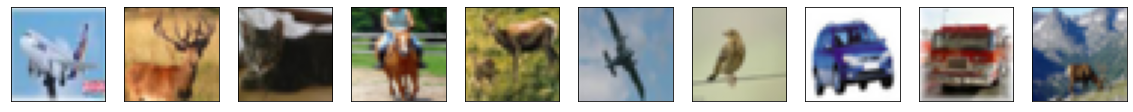

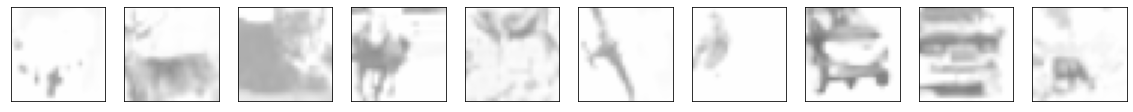

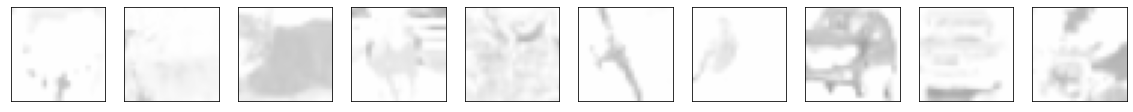

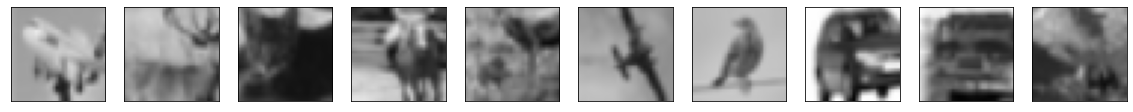

In [6]:
#checkout the augmentations
samp, lab = next(iter(train_ds_unlabeled))

def plot_images(samp):
  #plot figure
  fig, ax = plt.subplots(1, 10, figsize = (20, 2))
  
  for i, s in enumerate(samp[:10]):
    ax[i].imshow(s)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plot_images(samp)
plot_images(data_aug(samp))
plot_images(data_aug(samp))
plot_images(data_aug(samp))

In [31]:
#build the encoder block
def encoder():
  return keras.Sequential([
                           keras.Input(shape = (32, 32, 3)),
                           layers.Conv2D(16, kernel_size = 3, strides = 2, activation = 'relu'),
                           layers.Conv2D(32, kernel_size = 3, strides = 2, activation = 'relu'),
                           layers.Conv2D(64, kernel_size = 3, strides = 2, activation = 'relu'),
                           layers.Conv2D(64, kernel_size = 3, strides = 2, activation = 'relu'),
                           layers.Flatten(),
                           layers.Dense(256, activation = 'relu')])
  

#create the base model
base_model = keras.Sequential([
                               keras.Input(shape = (32, 32, 3)),
                               encoder(),
                               layers.Dense(10, activation = 'softmax')])

base_model.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = [keras.metrics.SparseCategoricalAccuracy(name = 'acc')],)

In [15]:
#train the model
base_history = base_model.fit(train_ds_labeled, epochs = 50, validation_data = test_ds)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 3s 198ms/step - loss: 2.2817 - acc: 0.1234 - val_loss: 2.2261 - val_acc: 0.1430
Epoch 2/50
10/10 [==============================] - 2s 187ms/step - loss: 2.1377 - acc: 0.2112 - val_loss: 2.0317 - val_acc: 0.2658
Epoch 3/50
10/10 [==============================] - 2s 181ms/step - loss: 2.0324 - acc: 0.2524 - val_loss: 1.9851 - val_acc: 0.2810
Epoch 4/50
10/10 [==============================] - 2s 186ms/step - loss: 1.9699 - acc: 0.2842 - val_loss: 1.9374 - val_acc: 0.3036
Epoch 5/50
10/10 [==============================] - 2s 183ms/step - loss: 1.9060 - acc: 0.3150 - val_loss: 1.8990 - val_acc: 0.3084
Epoch 6/50
10/10 [==============================] - 2s 183ms/step - loss: 1.8466 - acc: 0.3344 - val_loss: 1.8288 - val_acc: 0.3356
Epoch 7/50
10/10 [==============================] - 2s 182ms/step - loss: 1.7770 - acc: 0.3596 - val_loss: 1.7681 - val_acc: 0.3586
Epoch 8/50
10/10 [==============================] - 2s 188ms/step - loss: 1.7056 - acc:

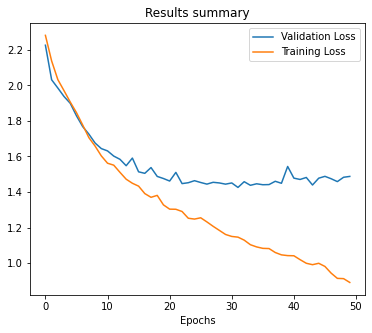

In [21]:
#plot
plt.figure(figsize = (6, 5))
plt.plot(np.arange(0, len(base_history.history['val_loss'])), base_history.history['val_loss'], label = 'Validation Loss')
plt.plot(np.arange(0, len(base_history.history['loss'])), base_history.history['loss'], label = 'Training Loss')
plt.legend()
plt.title('Results summary')
plt.xlabel('Epochs')
plt.show()

In [50]:
#contrastive model

#projection head
projection_head = keras.Sequential([
                                    keras.Input(shape = (256,)),
                                    layers.Dense(256, activation = 'relu'),
                                    layers.Dense(128, activation = 'relu'),
                                    layers.Dense(10, activation = 'softmax')
])

class ContrastiveLearningModel(keras.Model):
  def __init__(self):
    super().__init__()

    self.temp = temp
    self.contrastive_augmenter = data_aug()
    self.encoder = encoder()
    self.projection_head = projection_head()

  def contrasative_loss(self, aug_1, aug_2):

    #normalize
    aug_1 = tf.math.l2_normalize(aug_1, axis = 1)
    aug_2 = tf.math.l2_normalize(aug_2, axis = 1)

    #calculate cosine similarity
    cos_sim = tf.matmul(aug_1, aug_2, transpose_b = True)/self.temp
    

  def compile(self, contrastive_optimizer = 'Adam', **kwargs):
    super().compile(**kwargs)

    self.contrastive_optimizer = contrastive_optimizer
    

   

In [54]:
#create the SIMCLR model
tf.range(10)



<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>